# SMOTE XGBoost Model


# Load Packages


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, average_precision_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
import xgboost as xgb

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("All packages loaded successfully!")


All packages loaded successfully!


# Load Data


In [3]:
df = pd.read_csv('../data/stroke_data_prepared.csv')
print(f"Dataset shape: {df.shape}")
print(f"Features: {df.columns.tolist()}")
df.head()


Dataset shape: (5110, 17)
Features: ['id', 'age', 'avg_glucose_level', 'bmi', 'stroke', 'gender_Male', 'hypertension_Yes', 'heart_disease_Yes', 'ever_married_Yes', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']


,id,age,avg_glucose_level,bmi,stroke,gender_Male,hypertension_Yes,heart_disease_Yes,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,0.611111,3.712987,0.944444,1,1,0,1,1,0,1,0,0,1,1,0,0
1,51676,0.444444,2.994300,0.000000,1,0,0,0,1,0,0,1,0,0,0,1,0
2,31112,0.972222,0.380920,0.488889,1,1,0,1,1,0,1,0,0,0,0,1,0
3,60182,0.111111,2.153481,0.700000,1,0,0,0,1,0,1,0,0,1,0,0,1
4,1665,0.944444,2.231917,-0.455556,1,0,1,0,1,0,0,1,0,0,0,1,0


In [4]:
print("Target variable (stroke) distribution:")
print(df['stroke'].value_counts())
print(f"\nClass distribution:")
print(df['stroke'].value_counts(normalize=True))


Target variable (stroke) distribution:
stroke
0    4861
1     249
Name: count, dtype: int64

Class distribution:
stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64


# Data Preprocessing


In [5]:
X = df.drop(['stroke', 'id'], axis=1)
y = df['stroke']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Features: {list(X.columns)}")


Feature matrix shape: (5110, 15)
Target vector shape: (5110,)
Features: ['age', 'avg_glucose_level', 'bmi', 'gender_Male', 'hypertension_Yes', 'heart_disease_Yes', 'ever_married_Yes', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training target distribution (BEFORE SMOTE):")
print(y_train.value_counts(normalize=True))
print(f"Testing target distribution:")
print(y_test.value_counts(normalize=True))


Training set shape: (4088, 15)
Testing set shape: (1022, 15)
Training target distribution (BEFORE SMOTE):
stroke
0    0.951321
1    0.048679
Name: proportion, dtype: float64
Testing target distribution:
stroke
0    0.951076
1    0.048924
Name: proportion, dtype: float64


# Apply SMOTE to Training Data


In [7]:
print("Applying SMOTE to training data...")
print("="*60)
print("IMPORTANT: SMOTE is applied ONLY to training data!")
print("Test data remains unchanged to ensure valid evaluation.")
print("="*60)

smote = SMOTE(random_state=42, k_neighbors=5)

print(f"\nOriginal training set shape: {X_train.shape}")
print(f"Original class distribution:")
print(y_train.value_counts())

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"\nSMOTE-resampled training set shape: {X_train_smote.shape}")
print(f"New class distribution:")
print(pd.Series(y_train_smote).value_counts())
print(f"\nClass balance achieved: {pd.Series(y_train_smote).value_counts(normalize=True)}")


Applying SMOTE to training data...
IMPORTANT: SMOTE is applied ONLY to training data!
Test data remains unchanged to ensure valid evaluation.

Original training set shape: (4088, 15)
Original class distribution:
stroke
0    3889
1     199
Name: count, dtype: int64

SMOTE-resampled training set shape: (7778, 15)
New class distribution:
stroke
0    3889
1    3889
Name: count, dtype: int64

Class balance achieved: stroke
0    0.5
1    0.5
Name: proportion, dtype: float64


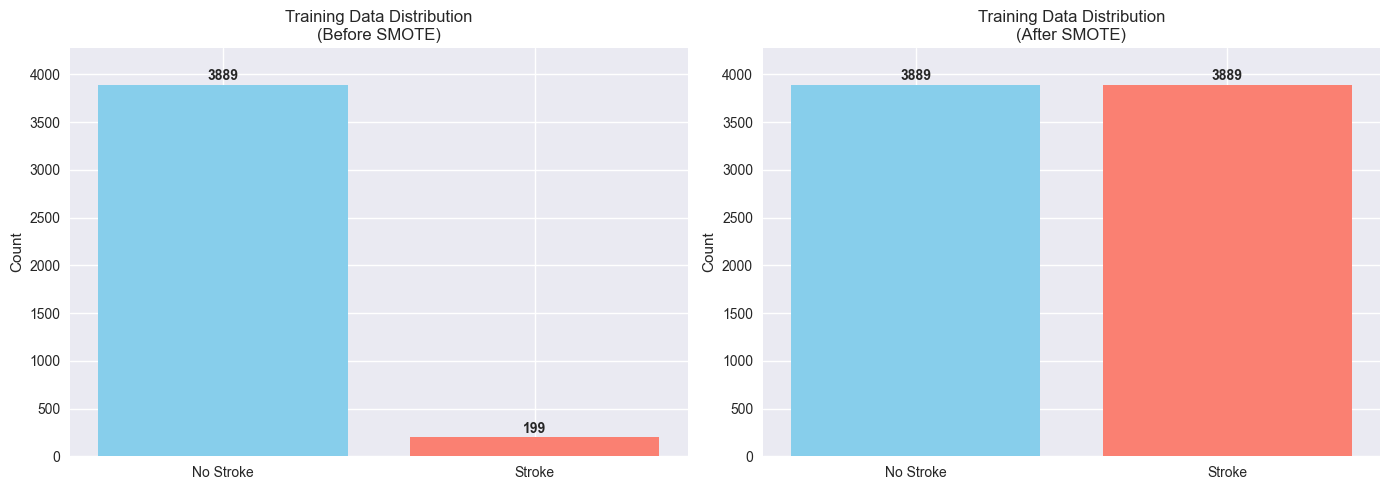

Synthetic samples generated: 3690


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE
y_train_counts = y_train.value_counts()
axes[0].bar(['No Stroke', 'Stroke'], y_train_counts.values, color=['skyblue', 'salmon'])
axes[0].set_title('Training Data Distribution\n(Before SMOTE)')
axes[0].set_ylabel('Count')
axes[0].set_ylim([0, max(y_train_counts.values) * 1.1])
for i, v in enumerate(y_train_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# After SMOTE
y_train_smote_counts = pd.Series(y_train_smote).value_counts()
axes[1].bar(['No Stroke', 'Stroke'], y_train_smote_counts.values, color=['skyblue', 'salmon'])
axes[1].set_title('Training Data Distribution\n(After SMOTE)')
axes[1].set_ylabel('Count')
axes[1].set_ylim([0, max(y_train_smote_counts.values) * 1.1])
for i, v in enumerate(y_train_smote_counts.values):
    axes[1].text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Synthetic samples generated: {len(X_train_smote) - len(X_train)}")


# SMOTE XGBoost Model


In [9]:
smote_model = xgb.XGBClassifier(
    tree_method='hist',  
    eval_metric='aucpr', 
    random_state=42
)

print("SMOTE XGBoost model created with default settings")
print("Key settings:")
print(f"  - Tree method: {smote_model.tree_method}")
print(f"  - Eval metric: {smote_model.eval_metric}")
print(f"  - Objective: {smote_model.objective}")
print(f"  - Training on SMOTE-resampled data: {X_train_smote.shape}")
print("\nFull model parameters:")
print(smote_model.get_params())


SMOTE XGBoost model created with default settings
Key settings:
  - Tree method: hist
  - Eval metric: aucpr
  - Objective: binary:logistic
  - Training on SMOTE-resampled data: (7778, 15)

Full model parameters:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'aucpr', 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 

In [10]:
print("Training SMOTE XGBoost model on resampled training data...")
smote_model.fit(X_train_smote, y_train_smote)
print("Model training completed!")


Training SMOTE XGBoost model on resampled training data...
Model training completed!


# Model Evaluation


In [11]:
y_pred = smote_model.predict(X_test)
y_pred_proba = smote_model.predict_proba(X_test)[:, 1]

print("Predictions completed!")


Predictions completed!


In [12]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
auprc = average_precision_score(y_test, y_pred_proba)

print("SMOTE Model Performance Metrics:")
print("="*45)
print(f"AUPRC (PRIMARY METRIC): {auprc:.4f}")
print("="*45)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")


SMOTE Model Performance Metrics:
AUPRC (PRIMARY METRIC): 0.1164
Accuracy:  0.9070
Precision: 0.1642
Recall:    0.2200
F1-Score:  0.1880
ROC-AUC:   0.7638


In [13]:
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       972
           1       0.16      0.22      0.19        50

    accuracy                           0.91      1022
   macro avg       0.56      0.58      0.57      1022
weighted avg       0.92      0.91      0.91      1022



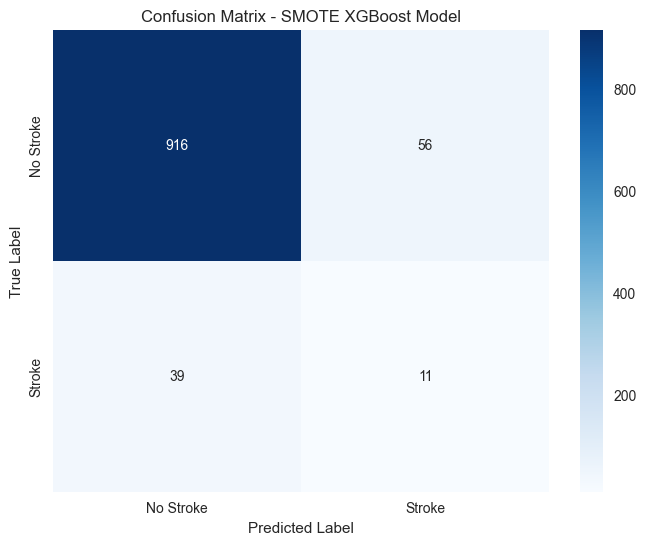

In [14]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Stroke', 'Stroke'], 
            yticklabels=['No Stroke', 'Stroke'])
plt.title('Confusion Matrix - SMOTE XGBoost Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


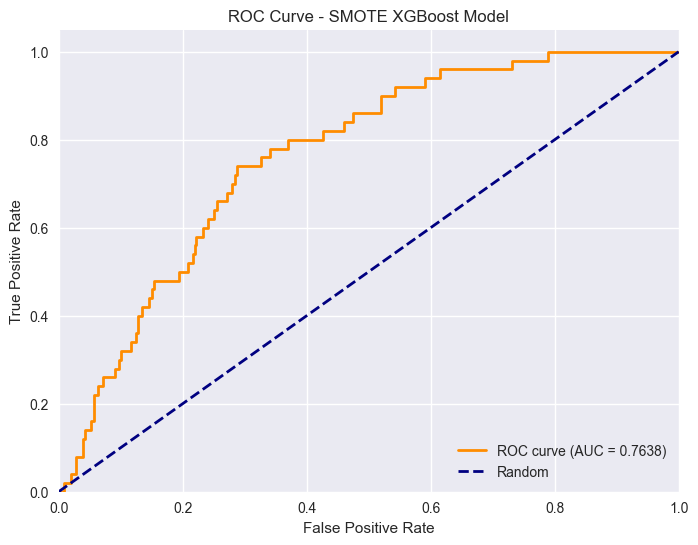

In [15]:
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SMOTE XGBoost Model')
plt.legend(loc="lower right")
plt.show()


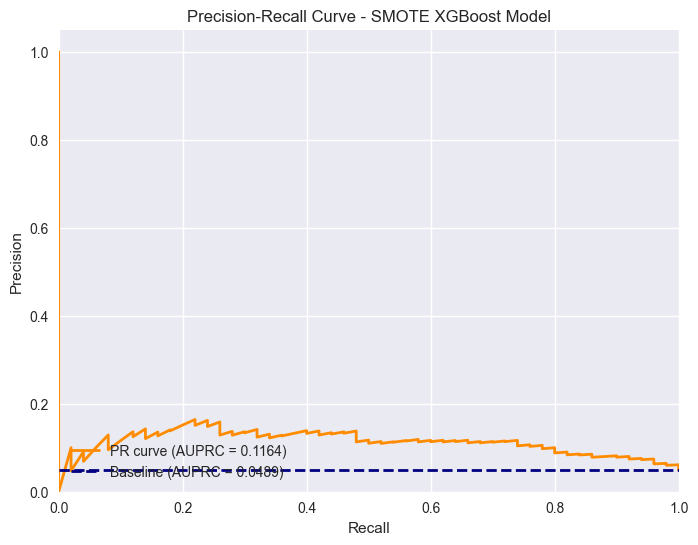

In [16]:
plt.figure(figsize=(8, 6))
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall_curve, precision_curve, color='darkorange', lw=2, 
         label=f'PR curve (AUPRC = {auprc:.4f})')

baseline = y_test.mean()
plt.axhline(y=baseline, color='navy', lw=2, linestyle='--', 
           label=f'Baseline (AUPRC = {baseline:.4f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - SMOTE XGBoost Model')
plt.legend(loc="lower left")
plt.show()


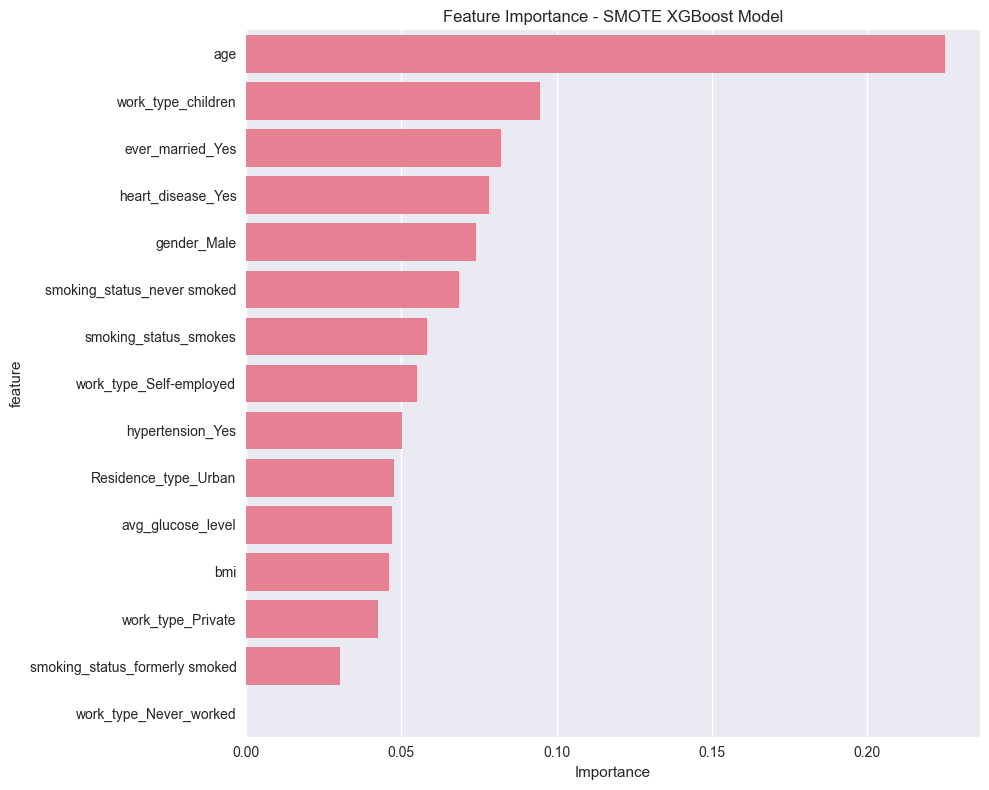

Top 5 Most Important Features:
               feature  importance
0                  age    0.225150
10  work_type_children    0.094653
6     ever_married_Yes    0.082232
5    heart_disease_Yes    0.078345
3          gender_Male    0.073932


In [17]:
plt.figure(figsize=(10, 8))
feature_importance = smote_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

sns.barplot(data=importance_df, x='importance', y='feature')
plt.title('Feature Importance - SMOTE XGBoost Model')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("Top 5 Most Important Features:")
print(importance_df.head())


# Exploring Different SMOTE Sampling Strategies


In [18]:
print("Testing different SMOTE sampling strategies...")
print("="*60)

sampling_strategies = {
    'Full Balance (1:1)': 1.0,
    'Moderate Balance (1:2)': 0.5,
    'Light Balance (1:3)': 0.33,
    'Minimal Balance (1:5)': 0.2
}

results = []

for strategy_name, strategy_ratio in sampling_strategies.items():
    print(f"\nTesting: {strategy_name} (ratio={strategy_ratio})")
    
    smote_temp = SMOTE(random_state=42, sampling_strategy=strategy_ratio, k_neighbors=5)
    X_train_temp, y_train_temp = smote_temp.fit_resample(X_train, y_train)
    
    model_temp = xgb.XGBClassifier(
        tree_method='hist',
        eval_metric='aucpr',
        random_state=42
    )
    
    model_temp.fit(X_train_temp, y_train_temp)
    
    y_pred_temp = model_temp.predict(X_test)
    y_pred_proba_temp = model_temp.predict_proba(X_test)[:, 1]
    
    accuracy_temp = accuracy_score(y_test, y_pred_temp)
    precision_temp = precision_score(y_test, y_pred_temp)
    recall_temp = recall_score(y_test, y_pred_temp)
    f1_temp = f1_score(y_test, y_pred_temp)
    roc_auc_temp = roc_auc_score(y_test, y_pred_proba_temp)
    auprc_temp = average_precision_score(y_test, y_pred_proba_temp)
    
    results.append({
        'Strategy': strategy_name,
        'Ratio': strategy_ratio,
        'Training Samples': len(X_train_temp),
        'AUPRC': auprc_temp,
        'Accuracy': accuracy_temp,
        'Precision': precision_temp,
        'Recall': recall_temp,
        'F1-Score': f1_temp,
        'ROC-AUC': roc_auc_temp
    })
    
    print(f"  Training samples: {len(X_train_temp)}")
    print(f"  AUPRC: {auprc_temp:.4f}")
    print(f"  Recall: {recall_temp:.4f}")
    print(f"  F1-Score: {f1_temp:.4f}")

results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("Strategy Comparison Complete!")


Testing different SMOTE sampling strategies...

Testing: Full Balance (1:1) (ratio=1.0)
  Training samples: 7778
  AUPRC: 0.1164
  Recall: 0.2200
  F1-Score: 0.1880

Testing: Moderate Balance (1:2) (ratio=0.5)
  Training samples: 5833
  AUPRC: 0.1344
  Recall: 0.1800
  F1-Score: 0.1622

Testing: Light Balance (1:3) (ratio=0.33)
  Training samples: 5172
  AUPRC: 0.1192
  Recall: 0.1200
  F1-Score: 0.1132

Testing: Minimal Balance (1:5) (ratio=0.2)
  Training samples: 4666
  AUPRC: 0.1411
  Recall: 0.1200
  F1-Score: 0.1348

Strategy Comparison Complete!


In [19]:
print("\nComplete Results Comparison:")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

best_auprc_idx = results_df['AUPRC'].idxmax()
best_strategy = results_df.loc[best_auprc_idx]

print(f"\nBest Strategy (by AUPRC): {best_strategy['Strategy']}")
print(f"  - AUPRC: {best_strategy['AUPRC']:.4f}")
print(f"  - Recall: {best_strategy['Recall']:.4f}")
print(f"  - F1-Score: {best_strategy['F1-Score']:.4f}")



Complete Results Comparison:
              Strategy  Ratio  Training Samples    AUPRC  Accuracy  Precision  Recall  F1-Score  ROC-AUC
    Full Balance (1:1)   1.00              7778 0.116373  0.907045   0.164179    0.22  0.188034 0.763827
Moderate Balance (1:2)   0.50              5833 0.134435  0.909002   0.147541    0.18  0.162162 0.785741
   Light Balance (1:3)   0.33              5172 0.119196  0.908023   0.107143    0.12  0.113208 0.776193
 Minimal Balance (1:5)   0.20              4666 0.141069  0.924658   0.153846    0.12  0.134831 0.798354

Best Strategy (by AUPRC): Minimal Balance (1:5)
  - AUPRC: 0.1411
  - Recall: 0.1200
  - F1-Score: 0.1348


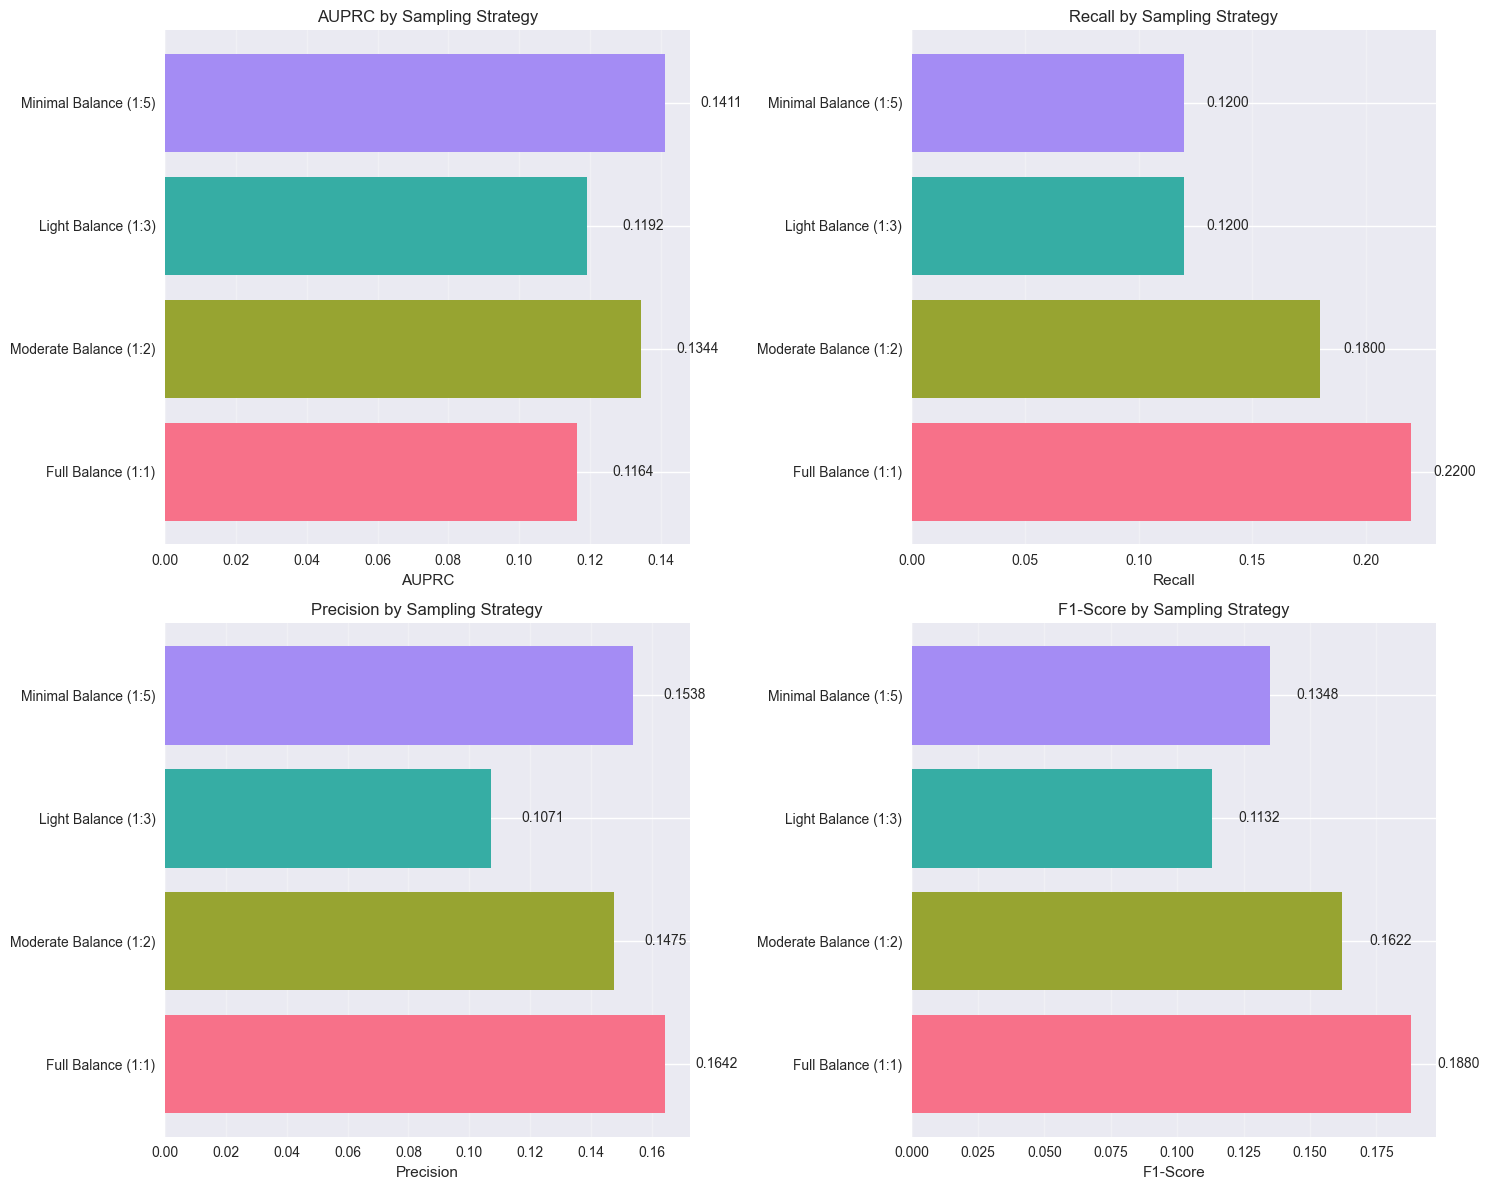

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

metrics = ['AUPRC', 'Recall', 'Precision', 'F1-Score']
colors_palette = sns.color_palette("husl", len(results_df))

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    ax.barh(results_df['Strategy'], results_df[metric], color=colors_palette)
    ax.set_xlabel(metric)
    ax.set_title(f'{metric} by Sampling Strategy')
    ax.grid(axis='x', alpha=0.3)
    
    for i, v in enumerate(results_df[metric]):
        ax.text(v + 0.01, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.show()


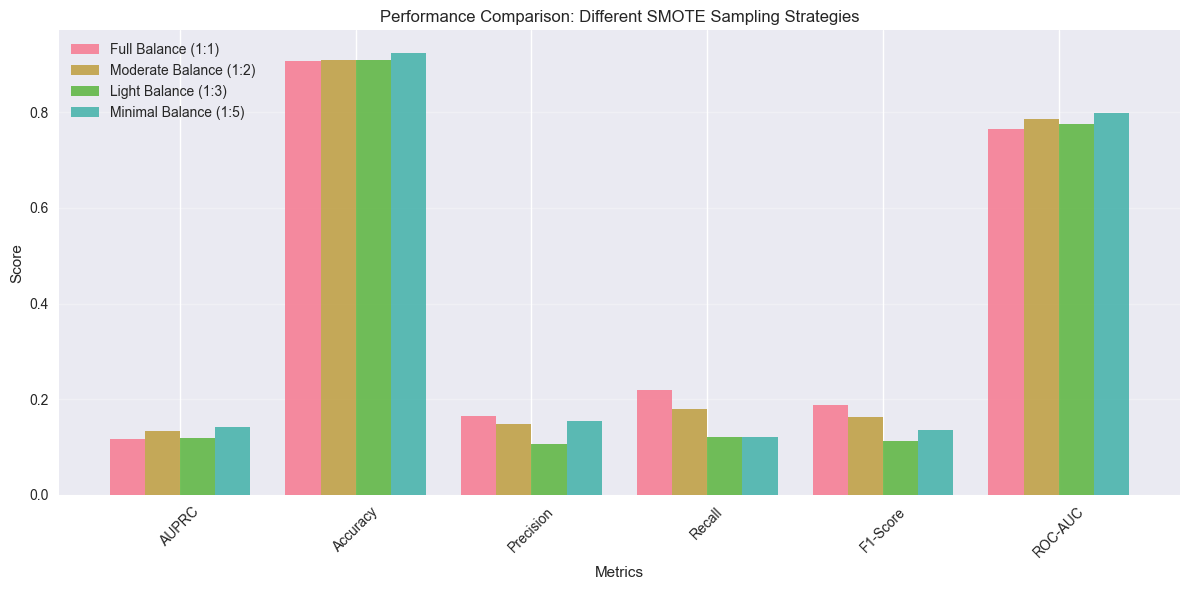

In [21]:
plt.figure(figsize=(12, 6))

metrics_to_plot = ['AUPRC', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics_to_plot))
width = 0.2

for i, (idx, row) in enumerate(results_df.iterrows()):
    values = [row[metric] for metric in metrics_to_plot]
    plt.bar(x + i * width, values, width, label=row['Strategy'], alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Comparison: Different SMOTE Sampling Strategies')
plt.xticks(x + width * 1.5, metrics_to_plot, rotation=45)
plt.legend(loc='best')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


# SMOTE Variants Comparison


In [22]:
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, SVMSMOTE

print("Testing different SMOTE variants...")
print("="*60)

smote_variants = {
    'SMOTE': SMOTE(random_state=42),
    'Borderline-SMOTE': BorderlineSMOTE(random_state=42),
    'SVM-SMOTE': SVMSMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42)
}

variant_results = []

for variant_name, smote_variant in smote_variants.items():
    print(f"\nTesting: {variant_name}")
    
    try:
        X_train_variant, y_train_variant = smote_variant.fit_resample(X_train, y_train)
        
        model_variant = xgb.XGBClassifier(
            tree_method='hist',
            eval_metric='aucpr',
            random_state=42
        )
        
        model_variant.fit(X_train_variant, y_train_variant)
        
        y_pred_variant = model_variant.predict(X_test)
        y_pred_proba_variant = model_variant.predict_proba(X_test)[:, 1]
        
        accuracy_variant = accuracy_score(y_test, y_pred_variant)
        precision_variant = precision_score(y_test, y_pred_variant)
        recall_variant = recall_score(y_test, y_pred_variant)
        f1_variant = f1_score(y_test, y_pred_variant)
        roc_auc_variant = roc_auc_score(y_test, y_pred_proba_variant)
        auprc_variant = average_precision_score(y_test, y_pred_proba_variant)
        
        variant_results.append({
            'Variant': variant_name,
            'Training Samples': len(X_train_variant),
            'AUPRC': auprc_variant,
            'Accuracy': accuracy_variant,
            'Precision': precision_variant,
            'Recall': recall_variant,
            'F1-Score': f1_variant,
            'ROC-AUC': roc_auc_variant
        })
        
        print(f"  Training samples: {len(X_train_variant)}")
        print(f"  AUPRC: {auprc_variant:.4f}")
        print(f"  Recall: {recall_variant:.4f}")
        print(f"  F1-Score: {f1_variant:.4f}")
        
    except Exception as e:
        print(f"  Error: {str(e)}")
        continue

variant_results_df = pd.DataFrame(variant_results)
print("\n" + "="*60)
print("SMOTE Variants Comparison Complete!")


Testing different SMOTE variants...

Testing: SMOTE
  Training samples: 7778
  AUPRC: 0.1164
  Recall: 0.2200
  F1-Score: 0.1880

Testing: Borderline-SMOTE
  Training samples: 7778
  AUPRC: 0.1195
  Recall: 0.1600
  F1-Score: 0.1481

Testing: SVM-SMOTE
  Training samples: 6117
  AUPRC: 0.1256
  Recall: 0.1400
  F1-Score: 0.1321

Testing: ADASYN
  Training samples: 7712
  AUPRC: 0.1470
  Recall: 0.2400
  F1-Score: 0.2051

SMOTE Variants Comparison Complete!


In [23]:
print("\nSMOTE Variants Results:")
print("="*80)
print(variant_results_df.to_string(index=False))
print("="*80)

best_variant_idx = variant_results_df['AUPRC'].idxmax()
best_variant = variant_results_df.loc[best_variant_idx]

print(f"\nBest Variant (by AUPRC): {best_variant['Variant']}")
print(f"  - AUPRC: {best_variant['AUPRC']:.4f}")
print(f"  - Recall: {best_variant['Recall']:.4f}")
print(f"  - F1-Score: {best_variant['F1-Score']:.4f}")



SMOTE Variants Results:
         Variant  Training Samples    AUPRC  Accuracy  Precision  Recall  F1-Score  ROC-AUC
           SMOTE              7778 0.116373  0.907045   0.164179    0.22  0.188034 0.763827
Borderline-SMOTE              7778 0.119493  0.909980   0.137931    0.16  0.148148 0.776502
       SVM-SMOTE              6117 0.125626  0.909980   0.125000    0.14  0.132075 0.789671
          ADASYN              7712 0.147012  0.909002   0.179104    0.24  0.205128 0.794918

Best Variant (by AUPRC): ADASYN
  - AUPRC: 0.1470
  - Recall: 0.2400
  - F1-Score: 0.2051


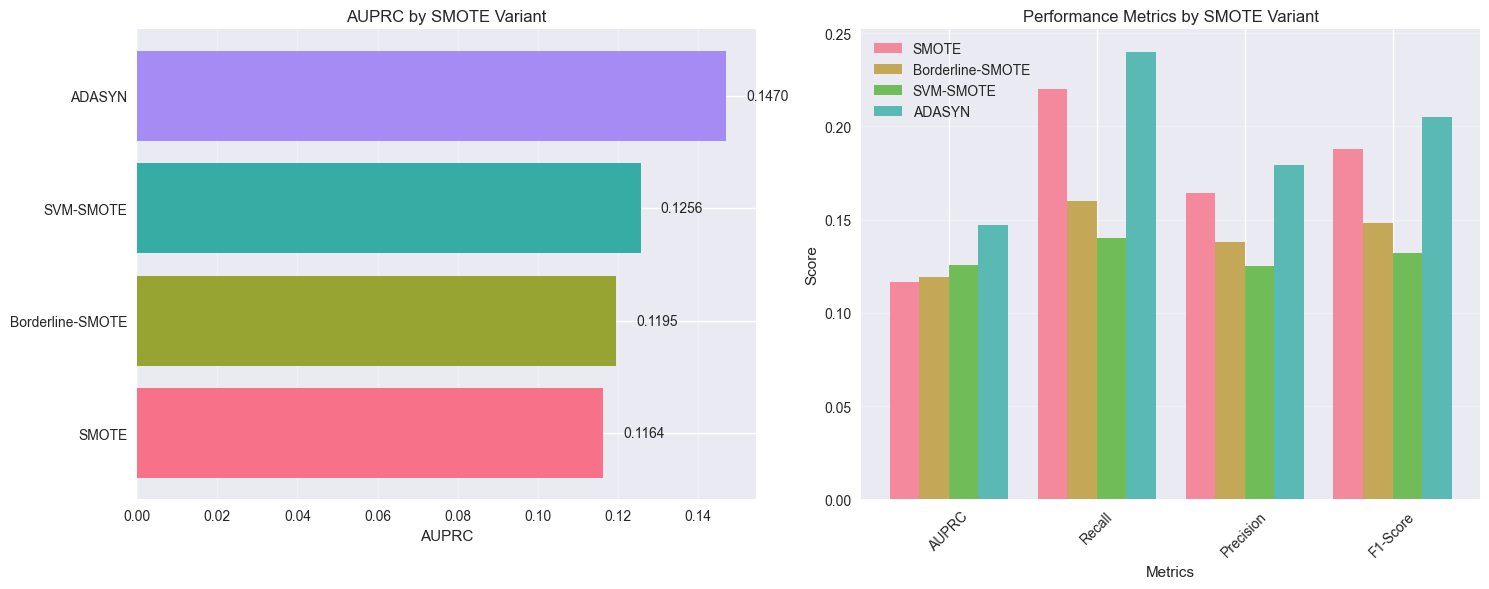

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# AUPRC comparison
colors_palette = sns.color_palette("husl", len(variant_results_df))
axes[0].barh(variant_results_df['Variant'], variant_results_df['AUPRC'], color=colors_palette)
axes[0].set_xlabel('AUPRC')
axes[0].set_title('AUPRC by SMOTE Variant')
axes[0].grid(axis='x', alpha=0.3)
for i, v in enumerate(variant_results_df['AUPRC']):
    axes[0].text(v + 0.005, i, f'{v:.4f}', va='center')

# Multi-metric comparison
metrics_to_plot = ['AUPRC', 'Recall', 'Precision', 'F1-Score']
x = np.arange(len(metrics_to_plot))
width = 0.2

for i, (idx, row) in enumerate(variant_results_df.iterrows()):
    values = [row[metric] for metric in metrics_to_plot]
    axes[1].bar(x + i * width, values, width, label=row['Variant'], alpha=0.8)

axes[1].set_xlabel('Metrics')
axes[1].set_ylabel('Score')
axes[1].set_title('Performance Metrics by SMOTE Variant')
axes[1].set_xticks(x + width * 1.5)
axes[1].set_xticklabels(metrics_to_plot, rotation=45)
axes[1].legend(loc='best')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


# Summary


In [25]:
print("SMOTE XGBoost Model Summary:")
print("="*50)
print(f"Dataset: Stroke Prediction ({X.shape[0]:,} samples, {X.shape[1]} features)")
print(f"Class Distribution: {(1-y.mean())*100:.1f}% No Stroke, {y.mean()*100:.1f}% Stroke")
print(f"Train/Test Split: {len(X_train):,} / {len(X_test):,}")
print(f"SMOTE Training Set: {len(X_train_smote):,} (added {len(X_train_smote) - len(X_train):,} synthetic samples)")
print()
print("Performance Metrics (1:1 Balance):")
print(f"  - AUPRC (PRIMARY): {auprc:.4f}")
print(f"  - Baseline AUPRC:  {y.mean():.4f}")
print(f"  - Accuracy:        {accuracy:.4f}")
print(f"  - Precision:       {precision:.4f}")
print(f"  - Recall:          {recall:.4f}")
print(f"  - F1-Score:        {f1:.4f}")
print(f"  - ROC-AUC:         {roc_auc:.4f}")
print()
print("Key Insights:")
print("  - SMOTE creates synthetic minority samples using k-nearest neighbors")
print("  - Applied ONLY to training data to prevent data leakage")
print("  - Test set remains unchanged for valid performance evaluation")
print("  - Different sampling strategies balance precision-recall tradeoff")


SMOTE XGBoost Model Summary:
Dataset: Stroke Prediction (5,110 samples, 15 features)
Class Distribution: 95.1% No Stroke, 4.9% Stroke
Train/Test Split: 4,088 / 1,022
SMOTE Training Set: 7,778 (added 3,690 synthetic samples)

Performance Metrics (1:1 Balance):
  - AUPRC (PRIMARY): 0.1164
  - Baseline AUPRC:  0.0487
  - Accuracy:        0.9070
  - Precision:       0.1642
  - Recall:          0.2200
  - F1-Score:        0.1880
  - ROC-AUC:         0.7638

Key Insights:
  - SMOTE creates synthetic minority samples using k-nearest neighbors
  - Applied ONLY to training data to prevent data leakage
  - Test set remains unchanged for valid performance evaluation
  - Different sampling strategies balance precision-recall tradeoff
